### American Community Survey 

Needs to be refactored

In [1]:
import sys
sys.path.append('../src')

import uschartbook.config

from uschartbook.config import *
from uschartbook.utils import *

import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Polygon
from matplotlib.patches import Rectangle
from matplotlib.colors import Normalize

plt.rc('font', family='Lato')

year = 2021

# Match PUMAs to commuter zones (file from Dorn)
cz_match = pd.read_stata(acs_dir / 'data/cw_puma2010_czone.dta')
cz_dict = {cz: [(puma, afactor) 
                for puma, z, afactor 
                in cz_match[cz_match['czone'] == cz].values] 
           for cz in cz_match['czone'].unique()}

### Age

In [2]:
# Read and pre-process ACS microdata
cols = ['ST', 'PUMA', 'PWGTP', 'AGEP']
dtypes = {'ST': str, 'PUMA': str}
puma = lambda x: x['ST'] + x['PUMA']
a65 = lambda x: np.where(x.AGEP >= 65, 1, 0)
u18 = lambda x: np.where(x.AGEP < 18, 1, 0)
yr = str(year)[2:]
files = [f'data/psam_pusa_{yr}.csv', f'data/psam_pusb_{yr}.csv']

df = pd.concat(
    [(pd.read_csv(acs_dir / file, usecols=cols, dtype=dtypes)
        .query('PWGTP > 0')
        .assign(PUMA = puma, 
                A65 = a65, 
                U18 = u18))
        [['PWGTP', 'PUMA', 'A65', 'U18']]
    for file in files]).astype({'PUMA': int})

In [3]:
d = {}
for cz, puma_list in cz_dict.items():
    pop = 0
    u18pop = 0
    a65pop = 0
    for puma, afactor in puma_list:  
        data = (df[df['PUMA'] == puma]
                  .assign(WGT = lambda x: x.PWGTP * afactor))
        pop += data.WGT.sum()
        u18pop += data.loc[data.U18 == 1, 'WGT'].sum()
        a65pop += data.loc[data.A65 == 1, 'WGT'].sum()
        
    u18sh = u18pop / pop
    o64sh = a65pop / pop
    results = {'Total': pop, 'Age 0-17': u18sh, 'Age 65+': o64sh}
    d[cz] = results
    
result = pd.DataFrame(d).T

result.to_csv(data_dir / 'acs_cz_age.csv', index_label='CZ90')

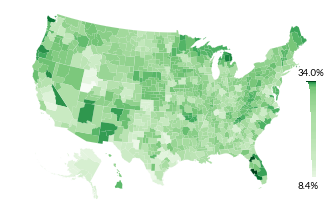

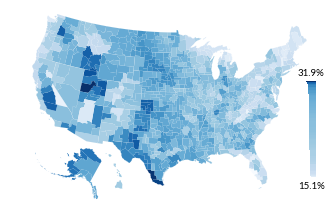

In [4]:
grps = [('Age 65+', 'over64pop.pgf', plt.cm.Greens), 
        ('Age 0-17', 'under18pop.pgf', plt.cm.Blues)]


for grp, filename, cmap in grps:
    maxval = result[grp].max()
    minval = result[grp].min()
    max_val = f'{maxval * 100:.1f}%'
    min_val = f'{minval * 100:.1f}%'

    norm = Normalize(vmin=minval, vmax=maxval)

    hi_cz = [35600, 34701, 34703, 34702, 34703]
    ak_cz = [34101, 34114, 34102, 34112, 34104, 34107, 34115, 
             34109, 34109, 34102, 34111, 34108, 34107, 34102, 
             34106, 34113, 34105, 34111, 34110, 34109, 34115, 
             34103, 34112, 34110, 34115]

    pts = np.arange(1, 101, 1)
    pct = (np.percentile(np.repeat(result[grp].values, 
                  result.Total.div(1000).astype(int).values), pts))

    # Map and legend settings
    m = Basemap(llcrnrlon=-121, llcrnrlat=20, urcrnrlon=-64, urcrnrlat=49,
                projection='lcc', lat_1=33, lat_2=45, lon_0=-95)

    fig = plt.figure(figsize=(5.0,2.5))

    m.drawmapboundary(color='white')
    m.readshapefile('/home/brian/Documents/ACS/shapefiles/cz1990', 'cz', drawbounds=False)

    ax = plt.gca()

    for info, shape in zip(m.cz_info, m.cz):
        fc = cmap(norm(d[info['cz']][grp]))
        if info['cz'] in hi_cz:
            shape = [[x + 5200000, y - 1400000] for x, y in shape]
        elif info['cz'] in ak_cz:
            shape = [(x * 0.34 + 1280000, 
                      y * 0.34 - 1300000) for x, y in shape]
        ax.add_patch(Polygon(shape, fc=fc))

    m.readshapefile('shapefiles/states', 'states', drawbounds=True, 
                    color='white', linewidth=0.05);
    ax.axis('off')    

    ax_inset = inset_axes(ax, width='-10%', height='50%', loc=4, borderpad=1.8) 
    for i, pt in enumerate(pct):
        rect = Rectangle(xy=(pt, i / 100), width=-pt, height=0.1, 
                         fc=cmap(norm(pt)), ec=None)
        ax_inset.add_patch(rect)    

    ax_inset.text(0.6, 1.05, max_val, fontsize=7)
    ax_inset.text(0.6, -0.12, min_val, fontsize=7)
    ax_inset.axis('off')
    plt.savefig(data_dir / filename, bbox_inches='tight', transparent=True)
    plt.show()

In [5]:
cz_names = (pd.read_excel(acs_dir / 'czlma903.xls', sheet_name='CZLMA903')
              .set_index('CZ90')
              .iloc[:, -1]
              .str.replace(' city', '')
              .str.replace(' town', '')
              .str.replace(' CDP', '')
              .str.replace(' \(remaind', '')
              .str.replace(' \(remain', '')
              .str.replace(' borough', '')
              .str.replace('Arlington, VA', 'Washington, DC')
              .to_dict())

size_cutoff = 100000

u18 = result.loc[result['Total'] > size_cutoff, 'Age 0-17'].sort_values()
o64 = result.loc[result['Total'] > size_cutoff, 'Age 65+'].sort_values()

u18.index = u18.index.map(cz_names)
o64.index = o64.index.map(cz_names)

/tmp/ipykernel_112775/97231850.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  cz_names = (pd.read_excel(acs_dir / 'czlma903.xls', sheet_name='CZLMA903')


In [6]:
v = {}
n = {}
for i in [-1, -2, -3, 0, 1, 2]:
    v[i] = f'{u18[i]*100:.1f}'
    n[i] = u18.index[i]

text = (f'In {year}, among commuter zones with a population of at least 100,000, '+
        'the commuter zone (listed by largest city) with the highest share of '+
        f'its population under 18 is {n[-1]} ({v[-1]} percent), followed by {n[-2]} '+
        f'({v[-2]} percent), and {n[-3]} ({v[-3]} percent). The commuter zones with '+
        f'lowest share of the local population under 18 were {n[0]} '+
        f'({v[0]} percent), {n[1]} ({v[1]} percent), and {n[2]} '+
        f'({v[2]} percent).')
print(text, '\n')
v = {}
n = {}
for i in [-1, -2, -3, 0, 1, 2]:
    v[i] = f'{o64[i]*100:.1f}'
    n[i] = o64.index[i]

text2 = ('The age 65 and older population is disproportionately concentrated in Florida. '+
         'The commuter zone with the highest share of its population over 64 is '+
         f'{n[-1]} ({v[-1]} percent), followed by {n[-2]} ({v[-2]} percent), '+
         f'and {n[-3]} ({v[-3]} percent). The commuter zones with lowest local over-'+
         f'64 population share were {n[0]} ({v[0]} percent), {n[1]} ({v[1]} percent), '+
         f'and {n[2]} ({v[2]} percent). ')
print(text2)
write_txt(text_dir / 'acs_u18.txt', text)
write_txt(text_dir / 'acs_o64.txt', text2)

In 2021, among commuter zones with a population of at least 100,000, the commuter zone (listed by largest city) with the highest share of its population under 18 is Provo, UT (31.9 percent), followed by Laredo, TX (31.5 percent), and Brownsville, TX (30.7 percent). The commuter zones with lowest share of the local population under 18 were Sarasota, FL (15.1 percent), Pittsfield, MA (16.4 percent), and Ocala, FL (16.7 percent). 

The age 65 and older population is disproportionately concentrated in Florida. The commuter zone with the highest share of its population over 64 is Sarasota, FL (34.0 percent), followed by Ocala, FL (32.9 percent), and Cape Coral, FL (30.4 percent). The commuter zones with lowest local over-64 population share were Provo, UT (8.4 percent), Laredo, TX (10.4 percent), and Odessa, TX (10.6 percent). 


### Employment

In [7]:
# Read and pre-process ACS microdata
cols = ['ST', 'PUMA', 'PWGTP', 'AGEP', 'WKWN', 'WKHP', 'COW']
dtypes = {'ST': str, 'PUMA': str}
puma = lambda x: x['ST'] + x['PUMA']
ftfy = lambda x: np.where((x.WKWN >= 50) & (x.WKHP > 34), 1, 0)
emp = lambda x: np.where(x.COW.isin(range(1,9)), 1, 0)
pa = lambda x: np.where(x.AGEP.isin(range(25,55)), 1, 0)
yr = str(year)[2:]
files = [f'data/psam_pusa_{yr}.csv', f'data/psam_pusb_{yr}.csv']

df = pd.concat(
    [(pd.read_csv(acs_dir / file, usecols=cols, dtype=dtypes)
        .query('PWGTP > 0')
        .assign(PUMA = puma, 
                FTFY = ftfy, 
                EMP = emp,
                PA = pa))
        [['PWGTP', 'PUMA', 'FTFY', 'EMP', 'PA']]
    for file in files]).astype({'PUMA': int})

In [8]:
d = {}
for cz, puma_list in cz_dict.items():
    pop = 0
    emp_pop = 0
    ftfy_pop = 0   
    pa_pop = 0
    pa_emp_pop = 0
    pa_ftfy_pop = 0
    for puma, afactor in puma_list:  
        data = (df[df['PUMA'] == puma]
                  .assign(WGT = lambda x: x.PWGTP * afactor))
        pop += data.WGT.sum()
        ftfy_pop += data.loc[data.FTFY == 1, 'WGT'].sum()
        emp_pop += data.loc[data.EMP == 1, 'WGT'].sum()
        pa_pop += data.loc[data.PA == 1, 'WGT'].sum()
        pa_emp_pop += data.loc[(data.PA == 1) & (data.EMP == 1), 'WGT'].sum()
        pa_ftfy_pop += data.loc[(data.PA == 1) & (data.FTFY == 1), 'WGT'].sum()
        
    fpop = ftfy_pop / pop
    epop = emp_pop / pop
    pa_epop = pa_emp_pop / pa_pop
    pa_ftfy = pa_ftfy_pop / pa_pop
    d[cz] = [fpop, epop, pop, pa_pop, pa_epop, pa_ftfy]
    
result = pd.DataFrame(d)
result.index = ['ftfy_share', 'emp_share', 'weight', 'pa_weight', 'pa_emp_share', 'pa_ftfy_share']
result = result.T

maxval = result.ftfy_share.max()
minval = result.ftfy_share.min()

In [9]:
# Map and legend settings
m = Basemap(llcrnrlon=-121, llcrnrlat=20, urcrnrlon=-64, urcrnrlat=49,
            projection='lcc', lat_1=33, lat_2=45, lon_0=-95)

cmap = plt.cm.winter_r
norm = Normalize(vmin=minval, vmax=maxval)

hi_cz = [35600, 34701, 34703, 34702, 34703]
ak_cz = [34101, 34114, 34102, 34112, 34104, 34107, 34115, 
         34109, 34109, 34102, 34111, 34108, 34107, 34102, 
         34106, 34113, 34105, 34111, 34110, 34109, 34115, 
         34103, 34112, 34110, 34115]

pts = np.arange(1, 101, 1)
pct = (np.percentile(
    np.repeat(result.ftfy_share.values, 
              result.weight.div(1000).astype(int).values), pts))

max_val = f'{maxval * 100:.1f}%'
min_val = f'{minval * 100:.1f}%'

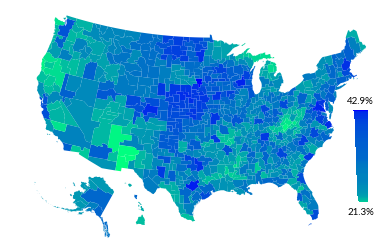

In [10]:
# Draw map
fig = plt.figure(figsize=(6.0,3.0))

m.drawmapboundary(color='white')
m.readshapefile('/home/brian/Documents/ACS/shapefiles/cz1990', 'cz', drawbounds=False)

ax = plt.gca()

for info, shape in zip(m.cz_info, m.cz):
    fc = cmap(norm(d[info['cz']][0]))
    if info['cz'] in hi_cz:
        shape = [[x + 5200000, y - 1400000] for x, y in shape]
    elif info['cz'] in ak_cz:
        shape = [(x * 0.34 + 1200000, 
                  y * 0.34 - 1300000) for x, y in shape]
    ax.add_patch(Polygon(shape, fc=fc))
    
m.readshapefile('shapefiles/states', 'states', drawbounds=True, 
                    color='white', linewidth=0.01, zorder=0) 

ax.axis('off')    

ax_inset = inset_axes(ax, width='-10%', height='40%', loc=4, borderpad=2.8) 
for i, pt in enumerate(pct):
    rect = Rectangle(xy=(pt, i / 100), width=-pt, height=0.1, 
                     fc=cmap(norm(pt)), ec=None)
    ax_inset.add_patch(rect)    

ax_inset.text(0.58, 1.06, max_val, fontsize=7)
ax_inset.text(0.58, -0.14, min_val, fontsize=7)
ax_inset.axis('off')
plt.savefig(data_dir / 'acs_emp_map.pgf', bbox_inches='tight', transparent=True);

In [11]:
cz_names = (pd.read_excel(acs_dir / 'czlma903.xls', sheet_name='CZLMA903')
              .set_index('CZ90')
              .iloc[:, -1]
              .str.replace(' city', '')
              .str.replace(' town', '')
              .str.replace(' CDP', '')
              .str.replace(' \(remaind', '')
              .str.replace(' \(remain', '')
              .str.replace('Arlington, VA', 'Washington, DC')
              .to_dict())

/tmp/ipykernel_112775/3350852207.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  cz_names = (pd.read_excel(acs_dir / 'czlma903.xls', sheet_name='CZLMA903')


In [12]:
size_cutoff = 100000

final = result.loc[result['weight'] > size_cutoff, 'ftfy_share'].sort_values()

final.index = final.index.map(cz_names)

In [13]:
file = 'acs_ftfy.txt'
f = text_dir / file
if file in os.listdir(text_dir):
    os.remove(f)

with open(f, 'a') as table:
    table.write('\scriptsize{Top 10:} \\\*' + '\n')
    for i in [-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
        r = f'\\textbf{{{final[i]*100:.1f}\%}} \hspace{{1mm}} {final.index[i]} \\\*'
        table.write(r + '\n')
        if i == -10:
            table.write('' + '\n')
            table.write('\scriptsize{Bottom 10:} \\\*' + '\n')

In [14]:
tot = len(result)
thirdsh = (len(result.loc[result.ftfy_share > 0.333]) / tot) * 100

qtrtot = len(result.loc[result.ftfy_share <= 0.25])
qtrsh = (len(result.loc[result.ftfy_share <= 0.25]) / tot) * 100
qtrpop = result.loc[result.ftfy_share <= 0.25, 'weight'].sum() / 1_000_000

text = (f'In {year}, {thirdsh:.1f} percent of commuter zones have '+
        'at least a third of their population working full-time and full-year. A '+
        f'total of {qtrtot} commuter zones (out of {tot}), covering {qtrpop:.1f} '+
        'million people, have a quarter of the population or less fully employed.')
print(text)
write_txt(text_dir / 'acs_ftfy_year.txt', str(year))
write_txt(text_dir / 'acs_ftfy_text.txt', text)

In 2021, 37.5 percent of commuter zones have at least a third of their population working full-time and full-year. A total of 19 commuter zones (out of 741), covering 2.6 million people, have a quarter of the population or less fully employed.


In [15]:
# Map and legend settings
m = Basemap(llcrnrlon=-121, llcrnrlat=20, urcrnrlon=-64, urcrnrlat=49,
            projection='lcc', lat_1=33, lat_2=45, lon_0=-95)

cmap = plt.cm.winter_r
maxval = result.pa_emp_share.max()
minval = result.pa_emp_share.min()
norm = Normalize(vmin=minval, vmax=maxval)

hi_cz = [35600, 34701, 34703, 34702, 34703]
ak_cz = [34101, 34114, 34102, 34112, 34104, 34107, 34115, 
         34109, 34109, 34102, 34111, 34108, 34107, 34102, 
         34106, 34113, 34105, 34111, 34110, 34109, 34115, 
         34103, 34112, 34110, 34115]

pts = np.arange(1, 101, 1)
pct = (np.percentile(
    np.repeat(result.pa_emp_share.values, 
              result.weight.div(1000).astype(int).values), pts))

max_val = f'{maxval * 100:.1f}%'
min_val = f'{minval * 100:.1f}%'

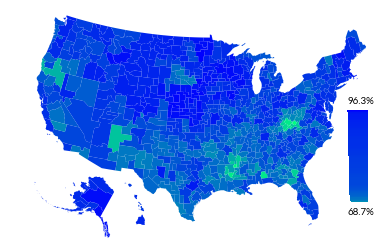

In [16]:
# Draw map
fig = plt.figure(figsize=(6.0,3.0))

m.drawmapboundary(color='white')
m.readshapefile('/home/brian/Documents/ACS/shapefiles/cz1990', 'cz', drawbounds=False)

ax = plt.gca()

for info, shape in zip(m.cz_info, m.cz):
    fc = cmap(norm(d[info['cz']][4]))
    if info['cz'] in hi_cz:
        shape = [[x + 5200000, y - 1400000] for x, y in shape]
    elif info['cz'] in ak_cz:
        shape = [(x * 0.34 + 1200000, 
                  y * 0.34 - 1300000) for x, y in shape]
    ax.add_patch(Polygon(shape, fc=fc))
    
m.readshapefile('shapefiles/states', 'states', drawbounds=True, 
                    color='white', linewidth=0.01, zorder=0) 

ax.axis('off')    

ax_inset = inset_axes(ax, width='-10%', height='40%', loc=4, borderpad=2.8) 
for i, pt in enumerate(pct):
    rect = Rectangle(xy=(pt*0.6, i / 100), width=-pt, height=0.1, 
                     fc=cmap(norm(pt)), ec=None)
    ax_inset.add_patch(rect)    

ax_inset.text(0.58, 1.06, max_val, fontsize=7)
ax_inset.text(0.58, -0.14, min_val, fontsize=7)
ax_inset.axis('off')
plt.savefig(data_dir / 'acs_emp_map2.pgf', bbox_inches='tight', transparent=True);

### Large city fully-employed rate data

In [17]:
size_cutoff = 4_500_000

final2 = result.loc[result['weight'] > size_cutoff].sort_values('weight', ascending=False)

final2.index = final2.index.map(cz_names)

file = '/home/brian/Documents/uschartbook/chartbook/data/acs_emp_tables.tex'

((final2[['ftfy_share', 'emp_share', 'pa_ftfy_share', 'pa_emp_share']].round(3) * 100.0)
 .to_csv(file, sep='&', line_terminator='\\\ ', quotechar=' ', header=False, float_format='%.1f'))

/tmp/ipykernel_112775/2406303424.py:9: FutureWarning: the 'line_terminator'' keyword is deprecated, use 'lineterminator' instead.
  ((final2[['ftfy_share', 'emp_share', 'pa_ftfy_share', 'pa_emp_share']].round(3) * 100.0)


### Low Income Share of Commuter Zone

In [18]:
# Read and pre-process ACS microdata
cols = ['ST', 'PUMA', 'WGTP', 'ADJINC', 'HINCP', 
        'NP', 'ADJHSG', 'GRNTP', 'SMOCP']
dtypes = {'ST': str, 'PUMA': str}
inc_adj = lambda x: (x['ADJINC'] / 1000000) * x['HINCP']
hsg_adj = lambda x: ((x['ADJHSG'] / 1000000) * x['GRNTP'].fillna(0) + 
                     (x['ADJHSG'] / 1000000) * x['SMOCP'].fillna(0)) * 12
puma = lambda x: x['ST'] + x['PUMA']
pp_inc = lambda x: x['INC_ADJ'] / x['NP']
yr = str(year)[2:]
files = [f'data/psam_husa_{yr}.csv', f'data/psam_husb_{yr}.csv']

df = pd.concat(
    [(pd.read_csv(acs_dir / file, usecols=cols, dtype=dtypes)
        .query('NP > 0')
        .assign(PUMA = puma, 
                INC_ADJ = inc_adj, 
                HSG_ADJ = hsg_adj, 
                PP_INC = pp_inc))
        [['PUMA', 'WGTP', 'PP_INC']]
    for file in files]).astype({'PUMA': int})

# Calculate threshold for map
percentile = 1/3
df.sort_values('PP_INC', inplace=True)
cumsum = df.WGTP.cumsum()
cutoff = df.WGTP.sum() * percentile
cutpoint = df.PP_INC[cumsum >= cutoff].iloc[0]
cutoff = f'\${cutpoint:,.0f}'
write_txt(text_dir / 'low_income_cz_cutoff.txt', cutoff)
print(f'Percentile {percentile * 100:.0f}: {cutoff}')

Percentile 33: \$21,495


In [19]:
d = {}
for cz, puma_list in cz_dict.items():
    pop = 0
    below_cut = 0    
    for puma, afactor in puma_list:  
        data = (df[df['PUMA'] == puma]
                  .assign(WGT = lambda x: x['WGTP'] * afactor))
        pop += data.WGT.sum()
        below_cut += data.loc[data['PP_INC'] < cutpoint, 'WGT'].sum()
        
    sh_below = below_cut / pop
    d[cz] = [sh_below, pop]
    
result = pd.DataFrame(d)
result.index = ['share', 'weight']
result = result.T

maxval = result.share.max()
minval = result.share.min()

# Map and legend settings
m = Basemap(llcrnrlon=-121, llcrnrlat=20, urcrnrlon=-64, urcrnrlat=49,
            projection='lcc', lat_1=33, lat_2=45, lon_0=-95)

cmap = plt.cm.rainbow
norm = Normalize(vmin=minval, vmax=maxval)

hi_cz = [35600, 34701, 34703, 34702, 34703]
ak_cz = [34101, 34114, 34102, 34112, 34104, 34107, 34115, 
         34109, 34109, 34102, 34111, 34108, 34107, 34102, 
         34106, 34113, 34105, 34111, 34110, 34109, 34115, 
         34103, 34112, 34110, 34115]

pts = np.arange(1, 101, 1)
pct = (np.percentile(
    np.repeat(result.share.values, 
              result.weight.div(1000).astype(int).values), pts))

max_val = f'{maxval * 100:.1f}%'
min_val = f'{minval * 100:.1f}%'

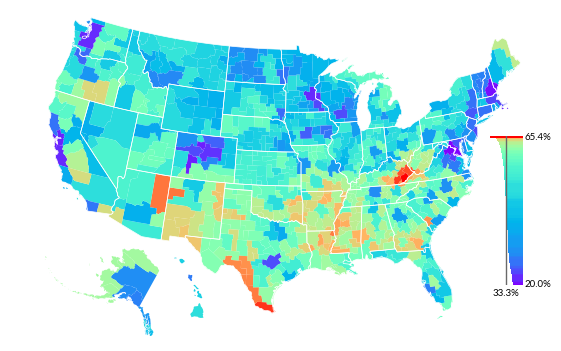

In [20]:
# Draw map
fig = plt.figure(figsize=(8.6,4.3))

m.drawmapboundary(color='white')
m.readshapefile('/home/brian/Documents/ACS/shapefiles/cz1990', 'cz', drawbounds=False)

ax = plt.gca()

for info, shape in zip(m.cz_info, m.cz):
    fc = cmap(norm(d[info['cz']][0]))
    if info['cz'] in hi_cz:
        shape = [[x + 5200000, y - 1400000] for x, y in shape]
    elif info['cz'] in ak_cz:
        shape = [(x * 0.34 + 1200000, 
                  y * 0.34 - 1300000) for x, y in shape]
    ax.add_patch(Polygon(shape, fc=fc))

m.readshapefile('shapefiles/states', 'states', drawbounds=True, 
                    color='white', linewidth=0.5)    
    
ax.axis('off')    

ax_inset = inset_axes(ax, width='-10%', height='45%', loc=4, borderpad=4) 
for i, pt in enumerate(pct):
    rect = Rectangle(xy=(pt, i / 100), width=-pt, height=0.1, 
                     fc=cmap(norm(pt)), ec=None)
    ax_inset.add_patch(rect)    

ax_inset.axvline(x=1/3, color='dimgray', zorder=1, lw=1)
ax_inset.text(1/3, -0.07, '33.3%', ha='center', fontsize=7)
ax_inset.text(-0.02, 0.98, max_val, fontsize=7)
ax_inset.text(-0.02, -0.01, min_val, fontsize=7)
ax_inset.axis('off')
plt.savefig('/home/brian/Documents/ACS/acs_map.pgf', bbox_inches='tight')

In [21]:
result.index = result.index.map(cz_names)
result['share'] = (result['share'] * 100).round(2)
result['weight'] = result['weight'].round()
result.to_csv(data_dir / 'low_income_cz.csv', index_label='name')

czn = len(result)
lin = len(result.query('share >= 50'))
lit = result.query('share >= 50').weight.sum() / 1_000_000
extreme = (result.query('share >= 55 and weight >= 39000')
                 .sort_values('share', ascending=False))
ex = [f'{x[0]} ({x[1]:.1f} percent)' 
      for x in extreme.iloc[:4].to_records()]

text = (f'Dividing the US into {czn} commuter zones, 66 '+
        f'of these zones, covering {lit:.1f} million people, '+
        'have a majority of the population in bottom '+
        'third of US income. Among the most extreme '+
        f'examples are {ex[0]}, {ex[1]}, {ex[2]}, and {ex[3]}. ')
write_txt(text_dir / 'low_income_cz.txt', text)
print(text)

Dividing the US into 741 commuter zones, 66 of these zones, covering 3.4 million people, have a majority of the population in bottom third of US income. Among the most extreme examples are Brownsville, TX (62.3 percent), Corbin, KY (61.9 percent), Pikeville, KY (60.9 percent), and Gallup, NM (58.5 percent). 
